(multilevel_hgf)=
# Hierarchical Bayesian modelling with probabilistic neural networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/3-Multilevel_HGF.ipynb)

In [1]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution, HGFPointwise
from pyhgf.model import HGF
from pyhgf.response import binary_softmax_inverse_temperature

plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
np.random.seed(123)

In the previous tutorials, we have fitted the binary, categorical and continuous Hierarchical Gaussian Filters (HGF) to observations to infer the values of specific parameters of the networks. proceeding this way, we were simulating computations occurring at the agent level (i.e. both the observations and actions were made by one agent, and we estimated the posterior density distribution of parameters for that agent). However, many situations in experimental neuroscience and computational psychiatry will require us to go one step further and to make inferences at the population level, therefore fitting many models at the same time and estimating the density distribution of hyper-priors (see for example case studies from {cite:p}`2014:lee`). 

Luckily, we already have all the components in place to do that. We already used Bayesian networks in the previous sections when we were inferring the distribution of some parameters. Here, we only had one agent (i.e. one participant), and therefore did not need any hyperprior. We need to extend this approach a bit, and explicitly state that we want to fit many models (participants) simultaneously, and draw the values of some parameters from a hyper-prior (i.e. the group-level distribution).

But before we move forward, maybe it is worth clarifying some of the terminology we use, especially as, starting from now, many things are called **networks** but are pointing to different parts of the workflow. We can indeed distinguish two kinds:
1. The predictive coding neural networks. This is the kind of network that [pyhgf](https://github.com/ComputationalPsychiatry/pyhgf) is designed to handle (see {ref}`probabilistic_networks`). Every HGF model is an instance of such a network.
2. The Bayesian (multilevel) network is the computational graph that is created with tools like [pymc](https://www.pymc.io/welcome.html). This graph will represent the dependencies between our variables and the way they are transformed.

In this notebook, we are going to create the second type of network and incorporate many networks of the first type in it as custom distribution.

## Simulate a dataset
We start by simulating a dataset containing the decisions from a group of participants undergoing a standard one-armed bandit task. We use the same binary time series as a reference as the previous tutorials. This would represent the association between the stimuli and the outcome, the experimenter controls this and here we assume all participants are presented with the same sequence of association.

In [4]:
u, _ = load_data("binary")

Using the same reasoning as in the previous tutorial {ref}`custom_response_functions`, we simulate the trajectories of beliefs from participants being presented with this sequence of observation. Here, we vary one parameter in the perceptual model, we assume that the tonic volatility ($\omega$) from the second level is sampled from a population distribution such as: 

$$
\omega_{2_i} \sim \mathcal{N}(-4.0, 1.0)
$$

This produces belief trajectories that can be used to infer propensity for decision at each time point. Moreover, we will assume that the decision function incorporates the possibility of a bias in the link between the belief and the decision in the form of the inverse temperature parameter, such as:

$$
P(A|\mu, t) = \frac{\mu^t}{\mu^t + (1-\mu)^t}
$$

Where $A$ is a positive association between the stimulus and the outcome, $\mu = \hat{\mu}_1^{(k)}$, the expected probability from the first level and $t$ is the temperature parameter. We sample the temperature parameter from a log-normal distribution to ensure positivity such as:

$$
z_{i} \sim \mathcal{N}(0.5, 0.5) \\
temperature = e^z
$$

In [5]:
def sigmoid(x, temperature):
    """The sigmoid response function with inverse temperature parameter."""
    return (x**temperature) / (x**temperature + (1 - x) ** temperature)

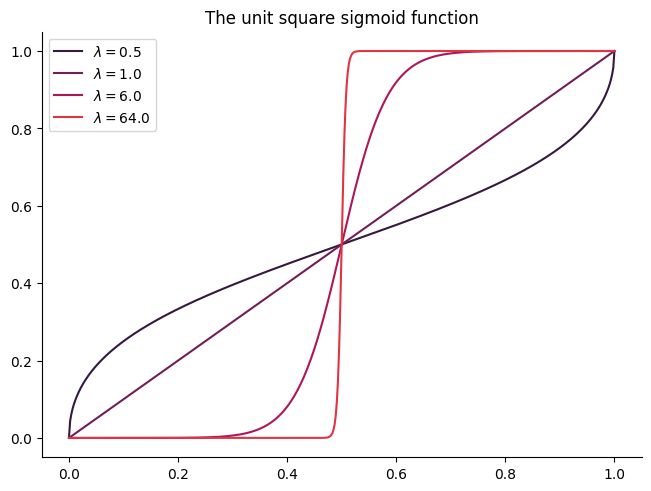

In [6]:
x = np.linspace(0, 1, 500)
sns.set_palette("rocket")
for temp in [0.5, 1.0, 6.0, 64.0]:
    plt.plot(x, sigmoid(x, temp), label=rf"$ \lambda = {temp}$")
plt.title("The unit square sigmoid function")
plt.legend()
sns.despine();

In [7]:
N = 10  # number of agents/participants in the study

# create just one default network - we will simply change the values of interest before fitting to save time
agent = HGF(
    n_levels=2,
    model_type="binary",
    initial_mean={"1": 0.5, "2": 0.0},
)

In [8]:
# observations (always the same), simulated decisions, sample values for temperature and volatility
responses = []
for i in range(N):
    # sample one new value of the tonic volatility at the second level and fit to observations
    volatility = np.random.normal(-4.0, 1.0)
    agent.attributes[1]["tonic_volatility"] = volatility
    agent.input_data(input_data=u)

    # sample one value for the inverse temperature (here in log space) and simulate responses
    temperature = np.exp(np.random.normal(0.5, 0.5))
    p = sigmoid(x=agent.node_trajectories[0]["expected_mean"], temperature=temperature)

    # store observations and decisions separately
    responses.append(np.random.binomial(p=p, n=1))
responses = np.array(responses)

## Group-level inference

In this section, we start embedding the HGF in a multilevel model using PyMC. We use the same core distribution (the [HGFDistribution class](pyhgf.distribution.HGFDistribution)) and leverage the possibility of automatic broadcasting to apply the same procedure to multiple HGF models in parallel. Note that the input data, time steps and responses should be provided as a Numpy array where the first dimension is the number of models to fit in parallel (in that case this corresponds to the number of participants). Thanks to automatic broadcasting, we can parametrize our distributions either using a float or using a vector that maps the number of models.

```{note} Using automatic broadcasting
To estimate group-level parameters, we will have to fit multiple models at the same time, either on different input data, on the same data with different parameters or on different datasets with different parameters. This step is handled natively both by the [log probability function](pyhgf.distribution.hgf_logp) and the [HGFDistribution class](pyhgf.distribution.HGFDistribution) using a pseudo [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) approach. When a list of *n* input time series is provided, the function will automatically apply *n* models using the provided parameters. If for some parameters an array of length *n* is provided, each model will use the n-th value as a parameter. Here, we are going to rely on this feature to compute the log probability of *n* model, using *n* time series as input and *n* different parameters to test.
```

```{hint} Observing the observer
As we explained in the first part of the tutorials, probabilistic networks *observe* their environment through the inputs they receive and update beliefs using inversion of the generative model they assume for this environment. Here, we are taking a step back and want to use actions from agents that we assume are using such networks to make decisions to infer the values of some parameters from those networks. This is often referred to as *observing the observer* and this comes with a different concept of observations. Here, observations are the behaviours we can observe from the network and are directly influenced by the response model we define (i.e. how an agent uses its beliefs to act on the environment). The input data that are fed to the network are fixed, therefore we declare it when we create the HGF function compatible with [PyTensor](https://pytensor.readthedocs.io). The actions, or responses we get from the participant, are the things we want to explain using the PyMC model, therefor we treat it as observation in a custom distribution, a distribution that can simulate the behaviour of HGF networks under a set of parameters.
```

In [9]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=u[np.newaxis, :].repeat(
        N, axis=0
    ),  # the inputs are the same for all agents - just duplicate the array
    response_function=binary_softmax_inverse_temperature,
    response_function_inputs=responses,
)

In [10]:
def logp(value, tonic_volatility_2, inverse_temperature):
    return hgf_logp_op(
        tonic_volatility_2=tonic_volatility_2,
        response_function_parameters=pt.flatten(inverse_temperature),
    )

In [11]:
logp(None, -3.0, 2.0).eval() 

array(-1938.53662109)

```{note} Pointwise log probabilities
Model comparison requires pointwise estimates of the log probabilities of a model (i.e. one estimate per observation), while the log-probability function used internally by the custom distribution works with the sum of the log-probabilities. We therefore need to compute this a second time without summing. We are doing this during inference using the [HGFPointwise class](pyhgf.distribution.HGFPointwise) class. This class works exactly like [HGFDistribution class](pyhgf.distribution.HGFDistribution) and should simply be treated as a deterministic variable for later use.
```

In [12]:
hgf_logp_op_pointwise = HGFPointwise(
    n_levels=2,
    model_type="binary",
    input_data=u[np.newaxis, :].repeat(
        N, axis=0
    ),  # the inputs are the same for all agents - just duplicate the array
    response_function=binary_softmax_inverse_temperature,
    response_function_inputs=responses,
)

In [13]:
def logp_pointwise(tonic_volatility_2, inverse_temperature):
    return hgf_logp_op_pointwise(
        tonic_volatility_2=tonic_volatility_2,
        response_function_parameters=inverse_temperature,
    )

In [14]:
with pm.Model() as two_levels_binary_hgf:

    # tonic volatility
    # ----------------
    mu_volatility = pm.Normal("mu_volatility", -5, 5)
    sigma_volatility = pm.HalfNormal("sigma_volatility", 10)
    volatility = pm.Normal(
        "volatility", mu=mu_volatility, sigma=sigma_volatility, shape=N
    )

    # inverse temperature
    # -------------------
    mu_temperature = pm.Normal("mu_temperature", 0, 2)
    sigma_temperature = pm.HalfNormal("sigma_temperature", 2)
    inverse_temperature = pm.LogNormal(
        "inverse_temperature", mu=mu_temperature, sigma=sigma_temperature, shape=N
    )

    # The multi-HGF distribution
    # --------------------------
    log_likelihood = pm.CustomDist(
        "log_likelihood",
        volatility,
        inverse_temperature,
        logp=logp,
        observed=responses,
    )

    # pointwise log-likelihoods
    # -------------------------
    pm.Deterministic(
        "pointwise_loglikelihood",
        logp_pointwise(volatility, inverse_temperature),
    )

### Plot the computational graph
The multilevel model includes hyperpriors over the mean and standard deviation of both the inverse temperature and the tonic volatility of the second level.

```{note}
We are sampling the inverse temperature in log space to ensure it will always be higher than 0, while being able to use normal hyper-priors at the group level.
```

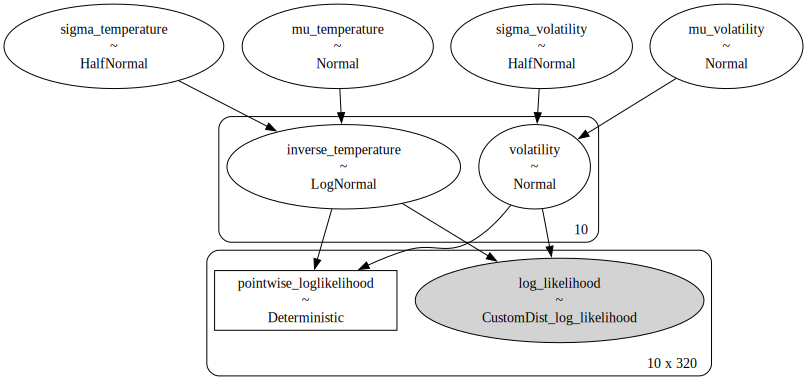

In [15]:
pm.model_to_graphviz(two_levels_binary_hgf)

### Sampling

In [16]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=2, cores=1)

Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [mu_volatility, sigma_volatility, volatility, mu_temperature, sigma_temperature, inverse_temperature]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
# save pointwise estimate as log_likelihood for later use in model comparison
two_level_hgf_idata.add_groups(
    log_likelihood=two_level_hgf_idata.posterior["pointwise_loglikelihood"]
)

### Visualization of the posterior distributions

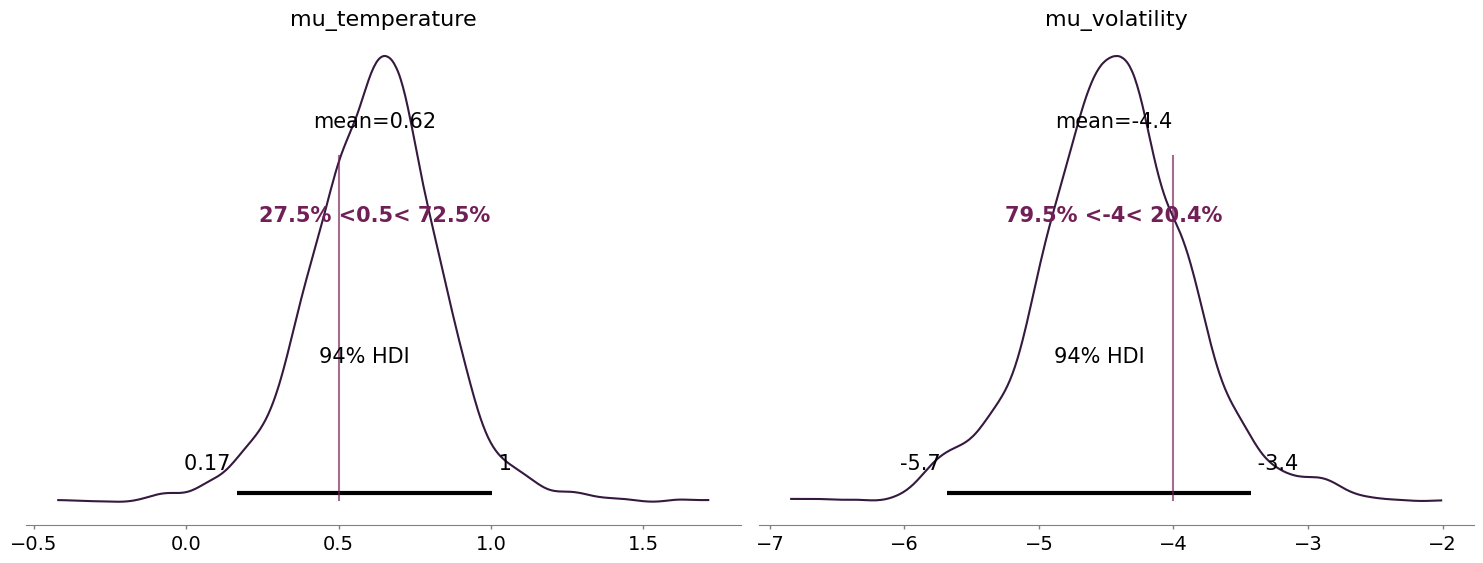

In [18]:
az.plot_posterior(
    two_level_hgf_idata,
    var_names=["mu_temperature", "mu_volatility"],
    ref_val=[0.5, -4.0],
);

The reference values on both posterior distributions indicate the mean of the distribution used for simulation.

## Model comparison

The posterior samples we get from [PyMC](https://www.pymc.io/welcome.html) are crucial to inform inference over parameter values, but they can also be helpful to compare different models that were fitted on the same observations. Here, we use leave-one-out cross-validation {cite:p}`Vehtari:2015`, which is the default method recommended by [Arviz](https://python.arviz.org/en/stable/). This function requires that the posterior samples also include pointwise estimates, it is therefore crucial to save this information during sampling, or alternativeæly to compute this manually from the samples a posteriori. We compute the expected log pointwise predictive density (ELPD) for one model, which indicates the quality of model fit (the higher the better). This quantity can be used to compare models side by side, provided that they are fitted to the same observed data.

In [19]:
%%capture --no-display
loo_hgf = az.loo(two_level_hgf_idata)

In [20]:
loo_hgf

Computed from 2000 posterior samples and 3200 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1684.05    25.63
p_loo       17.83        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     3186   99.6%
   (0.70, 1]   (bad)         2    0.1%
   (1, Inf)   (very bad)   12    0.4%

# System configuration

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Fri Jan 10 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.31.0

pyhgf : 0.2.1.post4.dev0+d49aafe9
jax   : 0.4.31
jaxlib: 0.4.31

sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
seaborn   : 0.13.2
matplotlib: 3.10.0
pytensor  : 2.26.4
pyhgf     : 0.2.1.post4.dev0+d49aafe9
numpy     : 1.26.0
IPython   : 8.31.0
arviz     : 0.20.0
pymc      : 5.20.0

Watermark: 2.5.0

